<a href="https://colab.research.google.com/github/aarohishaiva/CNN_final-Project/blob/main/Sequence_Modelling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install torch torchvision


Epoch 1/10, Loss: 1.1746
Epoch 2/10, Loss: 0.3709
Epoch 3/10, Loss: 0.2596
Epoch 4/10, Loss: 0.2399
Epoch 5/10, Loss: 0.2353
Epoch 6/10, Loss: 0.2332
Epoch 7/10, Loss: 0.2322
Epoch 8/10, Loss: 0.2316
Epoch 9/10, Loss: 0.2312
Epoch 10/10, Loss: 0.3802


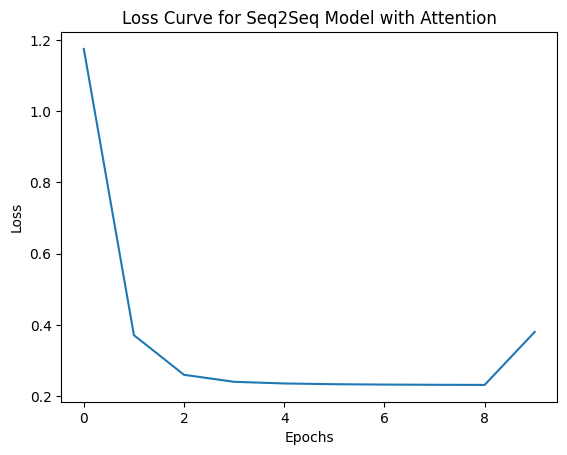

In [7]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader

# 1. Generate the Synthetic Dataset
class SequenceDataset(Dataset):
    def __init__(self, num_samples, seq_length):
        self.data = []
        for _ in range(num_samples):
            source_seq = np.random.randint(1, 10, size=seq_length)
            target_seq = source_seq[::-1]
            self.data.append((source_seq, target_seq))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        source_seq, target_seq = self.data[idx]
        return torch.tensor(source_seq.copy(), dtype=torch.long), torch.tensor(target_seq.copy(), dtype=torch.long)

# Parameters
num_samples = 10000
seq_length = 10
dataset = SequenceDataset(num_samples, seq_length)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# 2. Implement the Seq2Seq Model with Attention Mechanism
class Attention(nn.Module):
    def __init__(self, hidden_size):
        super(Attention, self).__init__()
        self.Wa = nn.Linear(hidden_size, hidden_size)
        self.Ua = nn.Linear(hidden_size, hidden_size)
        self.Va = nn.Linear(hidden_size, 1)

    def forward(self, hidden, encoder_outputs):
        # Expand the hidden state to match the encoder outputs
        hidden = hidden.unsqueeze(1)  # Add a dimension to match encoder outputs
        score = self.Va(torch.tanh(self.Wa(hidden) + self.Ua(encoder_outputs)))
        attention_weights = F.softmax(score, dim=1)
        context = attention_weights * encoder_outputs
        context = context.sum(dim=1)
        return context, attention_weights

class Encoder(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(Encoder, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.lstm = nn.LSTM(hidden_size, hidden_size, batch_first=True)

    def forward(self, x):
        embedded = self.embedding(x)
        outputs, (hidden, cell) = self.lstm(embedded)
        return outputs, hidden, cell

class Decoder(nn.Module):
    def __init__(self, output_size, hidden_size):
        super(Decoder, self).__init__()
        self.hidden_size = hidden_size
        self.attention = Attention(hidden_size)
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.lstm = nn.LSTM(hidden_size * 2, hidden_size, batch_first=True)  # Change input size to hidden_size * 2
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x, hidden, cell, encoder_outputs):
        context, _ = self.attention(hidden[-1], encoder_outputs)
        embedded = self.embedding(x.unsqueeze(1))  # Shape: (batch_size, 1, hidden_size)
        lstm_input = torch.cat((embedded, context.unsqueeze(1)), dim=2)  # Shape: (batch_size, 1, hidden_size * 2)
        output, (hidden, cell) = self.lstm(lstm_input, (hidden, cell))
        prediction = self.fc(output.squeeze(1))
        return prediction, hidden, cell

class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder):
        super(Seq2Seq, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, source, target):
        encoder_outputs, hidden, cell = self.encoder(source)
        outputs = torch.zeros(target.size(0), target.size(1), self.decoder.fc.out_features).to(source.device)

        # Initialize the first input to the decoder as the start token
        input = target[:, 0]

        for t in range(1, target.size(1)):
            output, hidden, cell = self.decoder(input, hidden, cell, encoder_outputs)
            outputs[:, t] = output
            input = target[:, t]  # Teacher forcing

        return outputs

# 3. Training the Model
# Parameters
input_size = 10  # Maximum value of random integers
output_size = 10
hidden_size = 64
num_epochs = 10
learning_rate = 0.001

# Initialize model, loss function, and optimizer
encoder = Encoder(input_size, hidden_size)
decoder = Decoder(output_size, hidden_size)
model = Seq2Seq(encoder, decoder)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# To store loss values
loss_values = []

# Training loop
for epoch in range(num_epochs):
    epoch_loss = 0
    for source, target in dataloader:
        optimizer.zero_grad()
        output = model(source, target)

        output_dim = output.shape[2]
        output = output[1:].reshape(-1, output_dim)  # Exclude the <sos> token
        target = target[1:].reshape(-1)  # Exclude the <sos> token

        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    avg_loss = epoch_loss / len(dataloader)
    loss_values.append(avg_loss)
    print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {avg_loss:.4f}')

# 4. Plotting Loss Curves
plt.plot(loss_values)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curve for Seq2Seq Model with Attention')
plt.show()
